2025-12-24 12:29:04.549024: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-24 12:29:04.587937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-24 12:29:04.587967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-24 12:29:04.589044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-24 12:29:04.595715: I tensorflow/core/platform/cpu_feature_guar

Using device: cuda
Loaded config:
{'B_VALIDATION': True,
 'CONFIG_NAME': 'CUB-200',
 'CUDA': True,
 'DATASET_NAME': 'CUB-200',
 'DATA_DIR': '../data/CUB-200',
 'GAN': {'BERT_NAME': 'bert-base-multilingual-cased',
         'B_ATTENTION': True,
         'B_DCGAN': True,
         'CONDITION_DIM': 100,
         'DF_DIM': 64,
         'GF_DIM': 128,
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': 0,
 'RNN_TYPE': 'LSTM',
 'TEXT': {'CAPTIONS_PER_IMAGE': 10,
          'DAMSM_NAME': '../Textencoder/text_encoder200.pth',
          'EMBEDDING_DIM': 256,
          'WORDS_NUM': 18},
 'TRAIN': {'BATCH_SIZE': 32,
           'B_NET_D': True,
           'DISCRIMINATOR_LR': 0.0001,
           'ENCODER_LR': 0.0002,
           'FLAG': True,
           'GENERATOR_LR': 0.0003,
           'MAX_EPOCH': 750,
           'NET_E': '',
           'NET_G': '../test',
           'NF': 32,
           'RNN_GRAD_CLIP': 0.25,
           'SMOOTH': {'GAMMA1': 5.0,
                      'GAMMA2': 5.0,
             

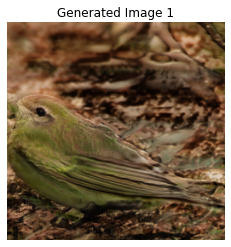

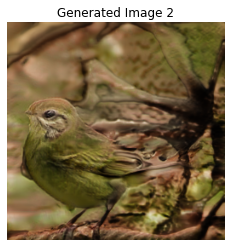

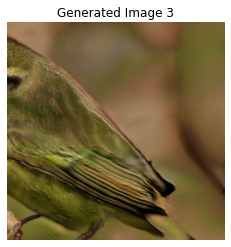

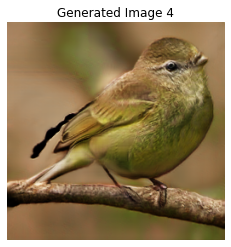

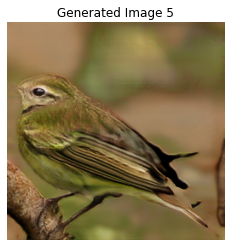

In [1]:
from __future__ import print_function

import os
import sys
import time
import random
import pprint
import argparse
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from miscc.utils import mkdir_p
from miscc.config import cfg, cfg_from_file
from datasets import prepare_data, TextBertDataset
from DAMSM import BERT_RNN_ENCODER
from model import NetG, NetD
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel
from transformers import BertTokenizer, BertModel

dir_path = os.getcwd()
sys.path.append(dir_path)

import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# Argument parser 
# =========================
def parse_args():
    parser = argparse.ArgumentParser(description='Text2Image')
    parser.add_argument('--cfg', dest='cfg_file', default='cfg/bird.yml', type=str)
    parser.add_argument('--gpu', dest='gpu_id', type=int, default=0)
    parser.add_argument('--data_dir', dest='data_dir', type=str, default='')
    parser.add_argument('--manualSeed', type=int, default=100)
    parser.add_argument('--evaluation', type=int, default=0)
    return parser.parse_args(args=[])

# ##########################
# Caption vectorization
# ##########################
def vectorize_caption(tokenizer, wordtoix, caption, copies=1):
    tokens = tokenizer.tokenize(caption.lower())

    cap_v = []
    for t in tokens:
        if t in wordtoix:
            cap_v.append(wordtoix[t])

    captions = np.zeros((copies, len(cap_v)))
    for i in range(copies):
        captions[i, :] = np.array(cap_v)

    cap_lens = np.zeros(copies) + len(cap_v)
    return captions.astype(int), cap_lens.astype(int)

# ##########################
# Image generation
# =========================
def generate(caption, tokenizer, text_encoder, netG, wordtoix, copies=1):
    captions, cap_lens = vectorize_caption(tokenizer, wordtoix, caption, copies)

    captions = Variable(torch.from_numpy(captions)).to(device)
    cap_lens = Variable(torch.from_numpy(cap_lens)).to(device)

    # Text embeddings
    hidden = text_encoder.init_hidden(captions.size(0))
    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)

    # Generate images
    with torch.no_grad():
        noise = torch.randn(captions.size(0), 100).to(device)
        fake_imgs = netG(noise, sent_emb)

    images = []
    for img in fake_imgs:
        img = img.cpu().numpy()
        img = (img + 1.0) * 127.5
        img = img.astype(np.uint8)
        img = np.transpose(img, (1, 2, 0))
        images.append(Image.fromarray(img))

    return images

# =========================
# Load models
# =========================
def load_model():
    args = parse_args()

    cfg_from_file(args.cfg_file)
    cfg.GPU_ID = args.gpu_id
    cfg.CUDA = torch.cuda.is_available()

    print("Loaded config:")
    pprint.pprint(cfg)

    # Load vocabulary
    filepath = os.path.join(cfg.DATA_DIR, 'hindi_captions1.pickle')
    x = pickle.load(open(filepath, 'rb'))
    wordtoix = x[3]
    word_len = len(wordtoix)

    # Generator
    netG = NetG(cfg.TRAIN.NF, 100).to(device)

    checkpoint_path = f"../models/{cfg.CONFIG_NAME}/checkpoint_nets.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    netG.load_state_dict(checkpoint['netG_state'])
    netG.eval()

    # Text encoder
    text_encoder = BERT_RNN_ENCODER(word_len, nhidden=cfg.TEXT.EMBEDDING_DIM)
    state_dict = torch.load(cfg.TEXT.DAMSM_NAME, map_location=device)
    state_dict.pop('encoder.embeddings.word_embeddings.weight', None)
    text_encoder.load_state_dict(state_dict, strict=False)
    text_encoder.to(device)
    text_encoder.eval()

    for p in text_encoder.parameters():
        p.requires_grad = False

    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained(cfg.GAN.BERT_NAME)

    return tokenizer, text_encoder, netG, wordtoix

# =========================
# LOAD EVERYTHING (RUN ONCE)
# =========================
tokenizer, text_encoder, netG, wordtoix = load_model()

# =========================
# Hindi T2I Interaction
# =========================
caption = input("Enter Hindi caption: ")
num_images = int(input("Number of images to generate: "))

images = generate(
    caption,
    tokenizer,
    text_encoder,
    netG,
    wordtoix,
    copies=num_images
)

# =========================######
# Visualaize the Generated Images
# =========================######
for i, img in enumerate(images):
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Generated Image {i+1}")
    plt.show()
